# Implementation of OU Model Mudchanatongsuk

This notebook demonstrates the usage of the `ou_model_mudchanatongsuk` module.

This module contains implementation of the following paper 

- [Optimal pairs trading: A stochastic control approach. (2008)](http://folk.ntnu.no/skoge/prost/proceedings/acc08/data/papers/0479.pdf) by Mudchanatongsuk, S., Primbs, J.A. and Wong, W.


## Introduction


In the paper corresponding to this module, the authors implement a stochastic control-based approach to the problem of pairs trading.
The paper models the log-relationship between a pair of stock prices as an Ornstein-Uhlenbeck process
and use this to formulate a portfolio optimization based stochastic control problem.
This problem is constructed in such a way that one may either
trade based on the spread (by buying and selling equal amounts of the stocks in the pair) or
place money in a risk-free asset. Then the optimal solution to this control problem
is obtained in closed form via the corresponding Hamilton-Jacobi-Bellman equation under a power utility on terminal wealth.


## Modelling


Let $A(t)$ and $B(t)$ denote respectively the prices of the
pair of stocks $A$ and $B$ at time $t$. The authors assume that stock $B$
follows a geometric Brownian motion,

$$
    d B(t)=\mu B(t) d t+\sigma B(t) d Z(t)
$$

where $\mu$ is the drift, $\sigma$ is the volatility, and $Z(t)$ is a standard
Brownian motion.

Let $X(t)$ denote the spread of the two stocks at time $t$,
defined as

$$
    X(t) = \ln(A(t)) − \ln(B(t))
$$

The authors assume that the spread follows an Ornstein-Uhlenbeck process

$$
    d X(t)=k(\theta-X(t)) d t+\eta d W(t)
$$

where $k$ is the rate of reversion, $\eta$ is the standard deviation and
$\theta$ is the long-term equilibrium level to which the spread reverts.

$\rho$ denotes the instantaneous correlation coefficient between $Z(t)$ and $W(t)$.

Let $V(t)$ be the value of a self-financing pairs-trading portfolio and
let $h(t)$ and $-h(t)$ denote respectively the
portfolio weights for stocks $A$ and $B$ at time $t$.


The wealth dynamics of the portfolio value is given by,

$$
    d V(t)= V(t)\left\{\left[h(t)\left(k(\theta-X(t))+\frac{1}{2} \eta^{2}+\rho \sigma \eta\right)+
    r\right] d t+\eta d W(t)\right\}
$$


Given below is the formulation of the portfolio optimization pair-trading problem
as a stochastic optimal control problem. The authors assume that an investor’s preference
can be represented by the utility function $U(x) = \frac{1}{\gamma} x^\gamma$
with $x ≥ 0$ and $\gamma < 1$. In this formulation, our objective is to maximize expected utility at
the final time $T$. Thus, the authors seek to solve


$$
    \begin{aligned}
    \sup _{h(t)} \quad & E\left[\frac{1}{\gamma}(V(T))^{\gamma}\right] \\[0.8em]
    \text { subject to: } \quad & V(0)=v_{0}, \quad X(0)=x_{0} \\[0.5em]
    d X(t)=& k(\theta-X(t)) d t+\eta d W(t) \\
    d V(t)=& V(t)((h(t)(k(\theta-X(t))+\frac{1}{2} \eta^{2}\\
    &+\rho \sigma \eta)+r) d t+\eta d W(t))
    \end{aligned}
$$

Finally, the optimal weights are given by,

$$
    h^{*}(t, x)=\frac{1}{1-\gamma}\left[\beta(t)+2 x \alpha(t)-\frac{k(x-\theta)}{\eta^{2}}+
    \frac{\rho \sigma}{\eta}+\frac{1}{2}\right]
$$


---

## How to use this submodule

This submodule contains three public methods. One for estimating the parameters of the model using training data,
and the second method is for calculating the final optimal portfolio weights using evaluation data.


### Imports and Loading the dataset

We use the $GLD$ and $GDX$ tickers daily close prices as our dataset. The training data comprises of data from years $2010$ to $2017$. The optimal weights are calculated on data from $2018$ to $2019$.

In [67]:
# Importing required modules
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import yfinance as yf

from arbitragelab.stochastic_control_approach.ou_model_mudchanatongsuk import OUModelMudchanatongsuk

# Importing GLD and GDX daily prices from yfinance
data1 =  yf.download("GLD GDX", start="2010-01-01", end="2017-12-31")
data2 =  yf.download("GLD GDX", start="2018-01-01", end="2020-01-01")

# Using the Adj Close prices for our dataset
data_train_dataframe = data1["Adj Close"][["GLD", "GDX"]]
data_test_dataframe = data2["Adj Close"][["GLD", "GDX"]]

[*********************100%***********************]  2 of 2 completed
[*********************100%***********************]  2 of 2 completed


### Fitting the model


We input the training data to the fit method which calculates the spread
and the estimators of the parameters of the model.


***
Although the paper provides closed form solutions for parameter estimation,
    this module uses log-likelihood maximization to estimate the parameters as we found the closed form solutions provided to be unstable.

***

In [68]:
# Creating an object of the Mudchanatongsuk class
sc = OUModelMudchanatongsuk()

# Calling the fit method on the train dataset
sc.fit(data_train_dataframe)

 To view the estimated model parameters from training data, we can use the `describe` function in the class object.

In [69]:
display(pd.DataFrame(sc.describe(), columns=['Values']))

,Values
Ticker of first stock,GLD
Ticker of second stock,GDX
long-term mean of spread,1.8269
rate of mean reversion of spread,0.276151
standard deviation of spread,0.281201
half-life of spread,2.51003
Drift of stock B,-0.00466583
standard deviation of stock B,0.384117


### Generating the Optimal Portfolio Weights


In this step we input the out-of-sample test data to calculate the optimal portfolio weights using the fitted model and specify the utility function parameter $\gamma$.

***
    As noted in the paper, please make sure the value of gamma is less than 1.
***

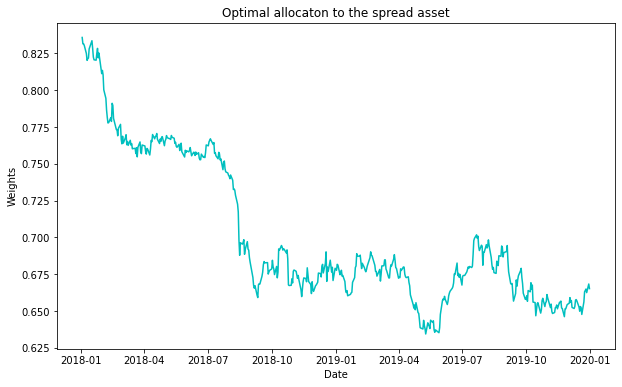

In [77]:
# In this example, we consider gamma = -10

# Plotting the portfolio weights of the spread asset
plt.figure(figsize=(10, 6))
weights = sc.optimal_portfolio_weights(data_test_dataframe, gamma = -10)
plt.plot(data_test_dataframe.index, weights, 'c-')
plt.title("Optimal allocaton to the spread asset")
plt.ylabel("Weights")
plt.xlabel("Date")
plt.show()

To calculate the wealth process we use the following equation,


$$
    \\
    d V(t)= V(t)\left\{\left[h(t)\left(k(\theta-X(t))+\frac{1}{2} \eta^{2}+\rho \sigma \eta\right)+
    r\right] d t+ d X(t) - k(\theta-X(t)) d t\right\}
    \\
$$


Here $d V(t)$ can be written as $V(t+1) - V(t)$ and,

$d X(t)$ can be written as $X(t+1) - X(t)$ .


In [78]:
def plot_wealth_process(obj, data, optimal_weights, r):
    """
    Function for plotting the wealth process.
    """
    
    tau, X = obj.spread_calc(data)
    V = np.ones(len(tau))

    for i in range(len(data) - 1):
        # Calculating the wealth process from spread and optimal weights.
        # Follows equation(8) and equation(4) in the paper.
        term_1 = optimal_weights[i] * (obj.k * (obj.theta - X[i]) + 0.5 * obj.eta ** 2
                                      + obj.rho * obj.sigma * obj.eta) + r
        V[i + 1] = V[i] +  V[i] * (term_1 * obj.delta_t + (X[i + 1] - X[i] - obj.k * (obj.theta - X[i]) * obj.delta_t))

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, V, 'c-')
    plt.title("Wealth process with initial wealth normalized to 1")
    plt.ylabel("Wealth")
    plt.xlabel("Date")
    plt.show()

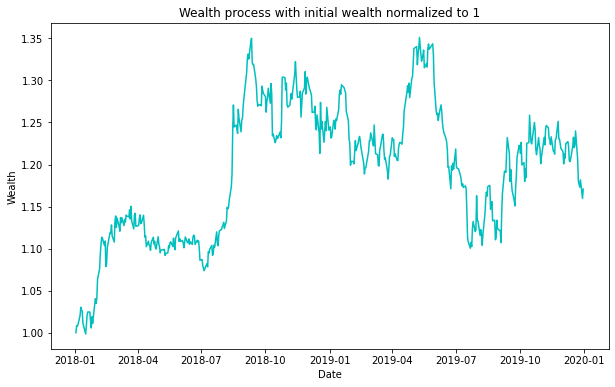

In [79]:
# Plots the corresponding wealth process for the calculated portolio weights above. 
plot_wealth_process(sc, data_test_dataframe, weights, 0.05)

Shown below is a plot of the pricing data of the two assets used to calculate the optimal portfolio weights.

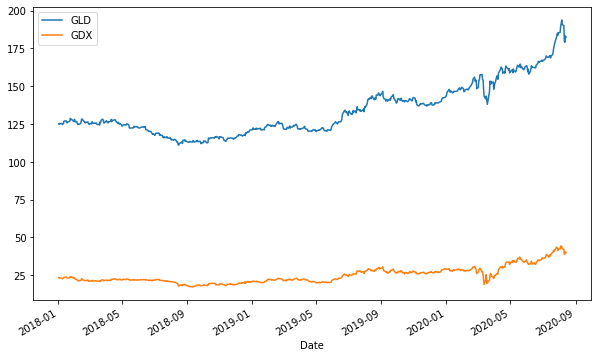

In [7]:
data_test_dataframe.plot(figsize=(10, 6));

---

## Conclusions

This notebook demonstrates an optimal pairs trading model using a stochastic control based approach. This model is detailed in the following paper:

[Optimal pairs trading: A stochastic control approach. (2008)](http://folk.ntnu.no/skoge/prost/proceedings/acc08/data/papers/0479.pdf) by Mudchanatongsuk, S., Primbs, J.A. and Wong, W.

**Key Takeaways:**

- The portfolio consists of the mean reverting spread and a risk free asset.
- The spread is constructed from the log prices of the two stocks and is delta neutral. This spread is modelled using an OU process.
- The investor preferences are represented by the power utility function.
- Here, `gamma` parameter is considered to be $<1$.
- The optimal portfolio weights generated do not depend on the rate of interest `r`.


## References

* [Optimal pairs trading: A stochastic control approach. (2008)](http://folk.ntnu.no/skoge/prost/proceedings/acc08/data/papers/0479.pdf) by Mudchanatongsuk, S., Primbs, J.A. and Wong, W.